In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import openpyxl
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [7]:
data = pd.read_csv('data/train.xls')

In [9]:

print(data.columns)
categorical_cols = data.select_dtypes(include=['object']).columns
final = data.drop(categorical_cols, axis=1)
y = final['SalePrice']
X = final.drop(columns=['SalePrice'])
print(X.shape)

scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
X_train = torch.nan_to_num(X_train, nan=0.0)  # Replace NaN with 0
y_train = torch.nan_to_num(y_train, nan=0.0)
dataset = TensorDataset(X_train, y_train)
# Create separate DataLoaders first
from torch.utils.data import DataLoader, random_split

# Assuming you have a full_dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset, batch_size=10)



# Define the model
model = nn.Sequential(
    nn.Linear(37, 23),
    nn.LeakyReLU(),
    nn.Linear(23, 9),
    nn.LeakyReLU(),
    nn.Linear(9, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 1)
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
training_losses = []  # Store training loss for each epoch
validation_losses = []  # Store validation loss for each epoch
# Training loop
epochs = 30
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    training_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_dataloader:
            val_predictions = model(batch_X)
            vloss = criterion(val_predictions, batch_y)
            val_loss += vloss.item()
    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    




Epoch [1/30], Train Loss: 38186127777.5534, Val Loss: 40775853614.5455
Epoch [2/30], Train Loss: 27113237464.2330, Val Loss: 12295571083.6364
Epoch [3/30], Train Loss: 8071619906.0777, Val Loss: 5528902498.9091
Epoch [4/30], Train Loss: 6128373885.2233, Val Loss: 4712669253.8182
Epoch [5/30], Train Loss: 5275630047.0680, Val Loss: 3826881221.8182
Epoch [6/30], Train Loss: 4380644178.0194, Val Loss: 3085661326.5455
Epoch [7/30], Train Loss: 3642224170.2330, Val Loss: 2736525704.7273
Epoch [8/30], Train Loss: 3095532140.1165, Val Loss: 2281331947.6364
Epoch [9/30], Train Loss: 2623703921.0874, Val Loss: 2056730807.2727
Epoch [10/30], Train Loss: 2271373641.8350, Val Loss: 1846226324.3636
Epoch [11/30], Train Loss: 2032617219.7282, Val Loss: 1687718132.3636
Epoch [12/30], Train Loss: 1849807268.3204, Val Loss: 1493266711.2727
Epoch [13/30], Train Loss: 1710589457.3981, Val Loss: 1417865992.7273
Epoch [14/30], Train Loss: 1604045608.3883, Val Loss: 1345929367.2727
Epoch [15/30], Train Loss

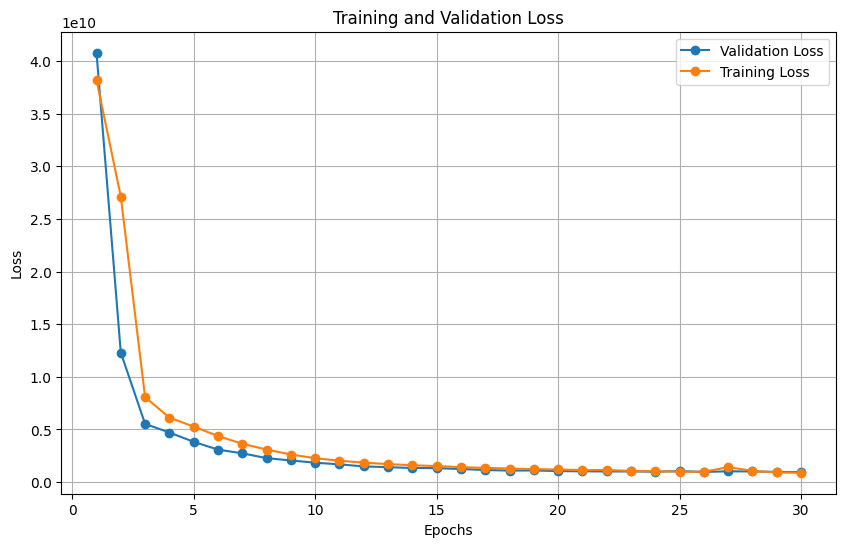

In [11]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', marker='o')
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Testing
model.eval()
test_loss = 0.0
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        predictions = model(batch_X)
        test_loss += criterion(predictions, batch_y).item()
        all_preds.extend(predictions.numpy())
        all_targets.extend(batch_y.numpy())
test_loss /= len(test_dataloader)

print(f"\nFinal Test Loss: {test_loss:.4f}")

# Additional metric (MAE)
mae = nn.L1Loss()
test_mae = mae(torch.tensor(all_preds), torch.tensor(all_targets))
print(f"Test MAE: {test_mae:.4f}")


Final Test Loss: 2486315276.7273
Test MAE: 25329.9434


C:\Users\jalle\AppData\Local\Temp\ipykernel_24636\1197664052.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  test_mae = mae(torch.tensor(all_preds), torch.tensor(all_targets))


In [17]:
# Testing with a sample input
test = pd.read_csv('data/test.xls')
categorical_cols = test.select_dtypes(include=['object']).columns
test = test.drop(categorical_cols, axis=1)
scaler = StandardScaler()
test = scaler.fit_transform(test)

sample_input = torch.tensor(test, dtype=torch.float32)
#sample_input = torch.nan_to_num(sample_input, nan=0.0)
model.eval()
predicted_value = model(sample_input)
predicted_value

tensor([[110027.8281],
        [159770.9062],
        [178722.9062],
        ...,
        [210002.5781],
        [        nan],
        [253932.1875]], grad_fn=<AddmmBackward0>)